# 0. Using a simple dataset "car object detection"

In [1]:
import PIL
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import torch
import torch.nn as nn
from torch.functional import F

import torchvision
from torchvision.ops import nms
from torchvision.ops import RoIPool

from torchvision.ops import boxes as box_ops

import pandas as pd
import os
import tqdm
import cv2

In [2]:
use_cuda = True
device = torch.device('cuda:4' if use_cuda else 'cpu')
x = torch.Tensor([0]).cuda(device)

# 1. 画框框之类的

In [3]:
# dataset的路径
path = 'data/car-object-detection/data/'

In [4]:
'''
    image file name: array([bbox1,bbox2])
'''
train_bbox_pd = pd.read_csv(path + 'train_solution_bounding_boxes.csv')
train_bbox_np = train_bbox_pd.to_numpy()
train_bbox = {}
for d in train_bbox_np:
    if d[0] not in train_bbox:
        train_bbox.update({d[0]:[d[1:]]})
    else:
        train_bbox[d[0]].append(d[1:])
train_bbox = {d:np.array(train_bbox[d]) for d in train_bbox}

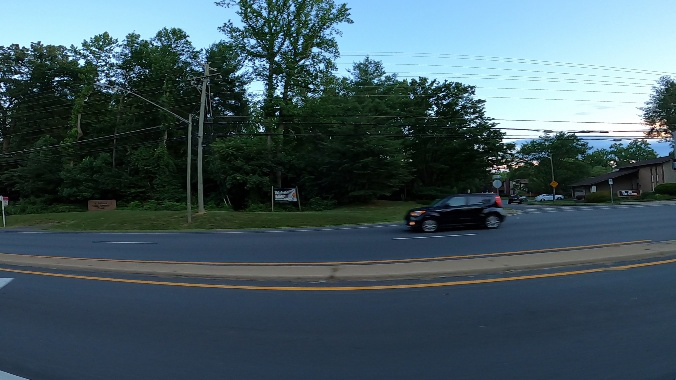

In [5]:
samplename = 'vid_4_10980.jpg'
img = Image.open(path + 'training_images/' + samplename)
img

In [6]:
train_bbox[samplename]

array([[398.6541245, 188.5022523, 518.0057887, 236.9192407]], dtype=object)

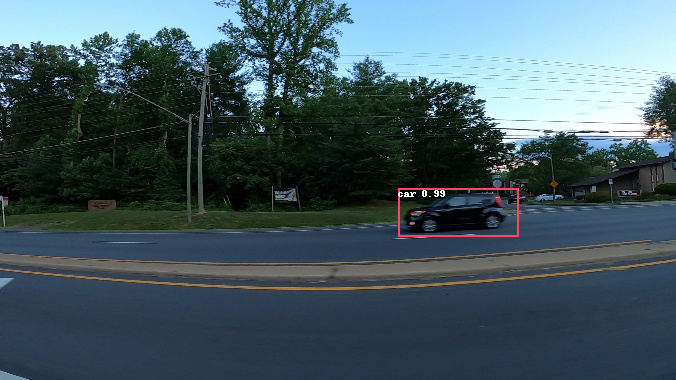

In [7]:
img11 = Image.open(path + 'training_images/' + samplename)
img = img11.copy()
img11.close()
def drawbbox(img):
    img1 = img.copy()
    ImageD = ImageDraw.Draw(img1)
    ImageD.rectangle([(398,188),(518,236)],outline='#FF4565',width = 2)
    ImageD.text((398,188),'car 0.99',fill = '#FFFFFF')
    return img1
img1 = drawbbox(img)
img1

# 2. Dataloader

In [8]:
# dataset的路径
path = 'data/car-object-detection/data/'
train_imagefile = [i for i in os.listdir(path + 'training_images') if i[-3:] == 'jpg']
test_imagefile = [i for i in os.listdir(path + 'testing_images') if i[-3:] == 'jpg']

In [9]:
class cardset(torch.utils.data.Dataset):
    def __init__(self, path = 'data/car-object-detection/data/'):
        super(cardset, self).__init__()
        self.path = path
        # 读取图像文件名
        self.train_imagefile = [i for i in os.listdir(path + 'training_images') if i[-3:] == 'jpg']
        self.test_imagefile = [i for i in os.listdir(path + 'testing_images') if i[-3:] == 'jpg']
        self.train_img = []
        self.test_img = []
        # 读取训练集的bbox
        train_bbox_pd = pd.read_csv(self.path + 'train_solution_bounding_boxes.csv')
        self.train_bbox_np = train_bbox_pd.to_numpy()
        self.train_bbox = {}
        self.idx2file = {}
        self.file2idx = {}
        i = 0
        for d in self.train_bbox_np:
            if d[0] not in self.train_bbox:
                self.train_bbox.update({d[0]:[d[1:]]})
                self.idx2file.update({i:d[0]})
                self.file2idx.update({d[0]:i})
                i += 1
            else:
                self.train_bbox[d[0]].append(d[1:])
        self.train_bbox = {d:np.array(self.train_bbox[d],dtype = np.float32) for d in self.train_bbox}
        # 读取数据到内存
        for filename in tqdm.tqdm(self.train_imagefile,desc = 'Reading train data'):
            img = Image.open(path + 'training_images/' + filename)
            self.train_img.append([filename,img])
            if filename not in self.train_bbox:
                self.train_bbox.update({filename:[]})
                self.idx2file.update({i:filename})
                self.file2idx.update({filename:i})
                i += 1
                
        for filename in tqdm.tqdm(self.test_imagefile,desc = 'Reading test data'):
            img = Image.open(path + 'testing_images/' + filename)
            self.test_img.append([filename,img])
            
    def __getitem__(self, index):
        if isinstance(self.train_img[index][1],(Image.Image)):
            self.train_img[index][1] = torchvision.transforms.functional.pil_to_tensor(self.train_img[index][1])/255
        img = self.train_img[index][1]
#         print(self.train_bbox[self.train_img[index][0]])
        label_num = self.file2idx[self.train_img[index][0]]
        return img, label_num
    
    def __len__(self):
        return len(self.train_img)

In [10]:
car = cardset()

Reading test data: 100%|██████████| 175/175 [00:00<00:00, 11118.23it/s]


In [11]:
import time

In [12]:
myiter = tqdm.tqdm(car,colour = '#111111')
myiter.set_description_str('y')
for x,y in myiter:
    pass
#     time.sleep(0.001)
#     print('\r',x.shape)

y: 100%|██████████| 1001/1001 [00:07<00:00, 139.28it/s]


In [13]:
car_dataloader = torch.utils.data.DataLoader(car, batch_size = 4, shuffle = False, num_workers = 0,pin_memory = True,drop_last = True)

In [14]:
myiter = tqdm.tqdm(car_dataloader,colour = '#0066FF')
myiter.set_description_str('car dataloader')
for x,y in myiter:
    pass

car dataloader: 100%|██████████| 250/250 [00:01<00:00, 170.39it/s]


In [15]:
x.shape

torch.Size([4, 3, 380, 676])

# 3. model 
Refer to [睿智的目标检测27——Pytorch搭建Faster R-CNN目标检测平台](https://blog.csdn.net/weixin_44791964/article/details/105739918)

## 3.1. backbone

In [16]:
resnet_model = torchvision.models.resnet50(pretrained = True)
resnet_model.cuda(device)
x.shape

torch.Size([4, 3, 380, 676])

In [17]:
x = x.cuda(device)

In [18]:
%%time
yy = resnet_model(x)

CPU times: user 25.9 ms, sys: 26.8 ms, total: 52.7 ms
Wall time: 71.8 ms


In [19]:
layers0_list =  [
                    resnet_model.conv1,
                    resnet_model.bn1,
                    resnet_model.relu,
                    resnet_model.maxpool,
                ]

In [20]:
layers0 = nn.Sequential(*layers0_list)
layers0.to(device)
layers1 = resnet_model.layer1
layers2 = resnet_model.layer2
layers3 = resnet_model.layer3

In [21]:
x.shape

torch.Size([4, 3, 380, 676])

In [22]:
'''
将预训练好的模型，拆分一下
'''
def resnet50_cls_fea(device):
    '''
        预训练的resnet model
    '''
    resnet_model = torchvision.models.resnet50(pretrained = True)
    '''
        特征提取网络，不使用FPN
    '''
    features_list = [
                        resnet_model.conv1,
                        resnet_model.bn1,
                        resnet_model.relu,
                        resnet_model.maxpool,
                        resnet_model.layer1,
                        resnet_model.layer2,
                        resnet_model.layer3,
                    ]
    features_model = nn.Sequential(*features_list).to(device)
    '''
        分类网络
    '''
    classifier_list = [resnet_model.layer4, resnet_model.avgpool]
    classifier = nn.Sequential(*classifier_list).to(device)
    
    return features_model,classifier

In [23]:
features_model,classifier = resnet50_cls_fea(device)

In [24]:
feature_map = features_model(x)

In [25]:
torch.cuda.empty_cache()

In [26]:
anchor_size = 9 
conv1 = nn.Conv2d(1024,1024,3,1,1).to(device)
score = nn.Conv2d(1024,anchor_size*2,1).to(device)
loc = nn.Conv2d(1024,anchor_size*4,1).to(device)

In [27]:
score_map = score(F.relu(conv1(feature_map)))
loc_map = loc(F.relu(conv1(feature_map)))

In [28]:
score_map.shape

torch.Size([4, 18, 24, 43])

In [29]:
score1 = score_map.permute(0,2,3,1).contiguous().view(score_map.shape[0],-1,2)

In [30]:
loc_map = loc_map.permute(0,2,3,1).contiguous().view(score_map.shape[0],-1,4).shape

In [31]:
score1 = F.softmax(score1,dim = -1)

## 3.2. RPN network

In [32]:
def generate_anchor_base(stride = 16, ratios=[0.5, 1, 2],
                         scales=[4, 8, 16]):
    '''
    Description:
        生成anchor的基础框，假设中心点(xc, yc) = (0, 0)
    Input:
        stride: pixel
        ratios: List, defaults:[0.5, 1, 2]
        scales: List, defaults:[4, 8, 16]
    output:
        anchor_base: shape:(num_ratios*num_scales, 4)
    Note:
        这个代码有点C++的风格！！
    '''
    '''
        预先开辟存放anchor地址空间
    '''
    anchor_base = np.zeros((len(ratios) * len(scales), 4), dtype=np.float32)
    for i in range(len(ratios)):
        for j in range(len(scales)):
            '''
                h: stride * scale * sqrt(ratio)
                w: stride * scale / sqrt(ratio)
            '''
            h = stride * scales[j] * np.sqrt(ratios[i])
            w = stride * scales[j] * np.sqrt(1. / ratios[i])
            '''
                index: i*num_scales + j ---- (address + offset)
            '''
            index = i * len(scales) + j
            '''
                假设中心点为(xc,yc) = (0, 0)
                xmin, ymin = xc - h/2, yc - w/2 = -h/2, -w/2
                xmax, ymax = xc + h/2, yc + w/2 = h/2, w/2
            '''
            anchor_base[index, 0] = - h / 2.
            anchor_base[index, 1] = - w / 2.
            anchor_base[index, 2] = h / 2.
            anchor_base[index, 3] = w / 2.
    '''
    output:
        anchor_base: shape:(num_ratios*num_scales, 4); defaults: (3x3, 4)->(9, 4)
    '''
    return anchor_base

In [33]:
def enumerate_shifted_anchor(anchor_base, feat_stride, height, width):
    '''
    Description:
        生成先验框, 用于选择ROI
    Input:
        anchor_base: 以(0, 0)为中心点的ancho框
        feat_stride: 原始图像的feat_stride倍下采样, 即feature map一个像素对应原图几个像素
        height: The height of feature map
        width: The width of feature map
    output:
        anchor: 先验框, shape: (num_anchor_base*height*width, 4)
    Note:
        因为与输入图像没有任何关系, 所以需要在forward中运行！！
    '''
    '''
    原始图像的中心点位置:
        shift_x: shape: (height,)
        shift_y: shape: (width, )
    '''
    shift_x = np.arange(0, width * feat_stride, feat_stride) + feat_stride/2
    shift_y = np.arange(0, height * feat_stride, feat_stride)+ feat_stride/2
    '''
    排列组合:
        shift_x: shape: (height, width)
        shift_y: shape: (height, width)
    '''
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    '''
    合并起来:
        shift: (shift_x, shift_y, shift_x, shift_y)
    '''
    shift = np.stack((shift_x.ravel(), shift_y.ravel(), 
                      shift_x.ravel(), shift_y.ravel()), 
                    axis = 1)
    '''
    anchor_base + 偏移
        利用了numpy的broadcast的性质：
            a: shape: (1, A, _)
            b: shape: (B, 1, _)
            c = a + b -> shape: (B, A, _)
    '''
    A = anchor_base.shape[0]
    B = shift.shape[0]
    anchor = anchor_base.reshape((1, A, 4)) + shift.reshape((B, 1, 4))
    '''
    改变维度
    '''
    anchor = anchor.reshape((B * A, 4)).astype(np.float32)
    '''
    output:
        anchor: 先验框, shape: (num_anchor_base*height*width, 4)
    '''
    return anchor

In [34]:
def locs2bbox(anchor, locs):
    '''
    Description:
        根据loc对src_bbox进行微调
    Input:
        anchor: (anchor_size, 4)
        locs: (anchor_size, 4)
    '''
    '''
        anchor原始的(xa, ya, ha, wa)
    '''
    anchor_width = anchor[:,2:3] -anchor[:,0:1]
    anchor_height = anchor[:,3:4] -anchor[:,1:2]
    anchor_xc = anchor[:,0:1] + anchor_width/2
    anchor_yc = anchor[:,1:2] + anchor_height/2
    '''
        locs：(dx, dy, dw, dh)
    '''
    dx = locs[:, 0::4]
    dy = locs[:, 1::4]
    dw = locs[:, 2::4]
    dh = locs[:, 3::4]
    '''
        获得微调后的anchor target
        xt = dx*wa + xa
        yt = dy*ha + ya
        wt = exp(dw)*wa
        ht = exp(dh)*ha
    '''
    xt = dx * anchor_width + anchor_xc
    yt = dy * anchor_height + anchor_yc
    wt = torch.exp(dw)*anchor_width
    ht = torch.exp(dh)*anchor_height
    '''
        变成xmin, ymin, xmax, ymax格式
    '''
    xmin = xt - wt/2
    ymin = yt - ht/2
    xmax = xt + wt/2
    ymax = yt + ht/2
    anchor_pre = torch.hstack((xmin,ymin,xmax,ymax))
    '''
    Output:
        anchor_pre：经过微调过的先验框
    '''
    return anchor_pre

In [35]:
class ProposalCreator():
    def __init__(self, mode, nms_thresh = 0.7,
                    n_train_pre_nms=12000,
                    n_train_post_nms=600,
                    n_test_pre_nms=3000,
                    n_test_post_nms=300,
                    min_size=16
                ):
        '''
        Description:
            用于生成proposal layer, pytorch上为filter proposal
        Input:
            mode: training or testing
            n_train_pre_nms: 获取前n_train_pre_nms个得分最高的数据
            n_train_post_nms: 用非极大值移植
            n_test_pre_nms: 获取前n_test_pre_nms个得分最高的数据
            n_test_post_nms: 用非极大值移植
            min_size: proposal框的高与宽最小值
        '''
        '''
        保存输入的变量
        '''
        self.mode = mode
        self.nms_thresh = nms_thresh
        self.n_train_pre_nms = n_train_pre_nms
        self.n_train_post_nms = n_train_post_nms
        self.n_test_pre_nms = n_test_pre_nms
        self.n_test_post_nms = n_test_post_nms
        self.min_size = min_size
        
    def __call__(self, anchor_pre, scores, img_size, scale = 1):
        '''
        Input:
            anchor: 先验anchor
            rpn_fg_scores: 先验anchor为前景的分数(概率)
            loc: anchor的微调
            img_size: To prevent anchors from beyonding the image area
            scale: Determine the minimal size of anchor
        Output:
            roi: shape:(num_roi, 4)
        '''
        '''
            判断是出于训练阶段还是预测阶段, 训练时的proposal比较多一点
        '''
        if self.mode == "training":
            n_pre_nms = self.n_train_pre_nms
            n_post_nms = self.n_train_post_nms
        else:
            n_pre_nms = self.n_test_pre_nms
            n_post_nms = self.n_test_post_nms

        '''
            将anchor_pre超出图像的部分截掉
        '''
        anchor_pre[:,[0,2]] = torch.clamp(anchor_pre[:,[0,2]], min = 0, max = img_size[1] - 1)
        anchor_pre[:,[1,3]] = torch.clamp(anchor_pre[:,[1,3]], min = 0, max = img_size[0] - 1)
        '''
            将anchor_pre宽高过小的剔除掉
        '''
        min_size = self.min_size * scale
        keep = torch.where(((anchor_pre[:,2] - anchor_pre[:,0])>=min_size)&((anchor_pre[:,3] - anchor_pre[:,1])>=min_size))[0]
        roi = anchor_pre[keep,:]
        roi_scores = scores[keep]
        '''
            提取前n_pre_nms的数据
        '''
        order = torch.argsort(roi_scores,descending=True)
        if n_pre_nms > 0:
            order = order[:n_pre_nms]
            roi = roi[order, :]
            roi_scores = roi_scores[order]
        '''
            非极大值抑制NMS
        '''
        keep = nms(roi, roi_scores, self.nms_thresh)
        keep = keep[:n_post_nms]
        roi = roi[keep, :]
        roi_scores = roi_scores[keep]
        '''
        Output:
            roi: shape:(num_roi, 4)
        '''
        return roi, roi_scores

In [36]:
def normal_init(m, mean, stddev, truncated=False):
    '''
        Does it really work?
    '''
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()

In [37]:
def encode_boxes(reference_boxes, proposals, weights):
    # type: (torch.Tensor, torch.Tensor, torch.Tensor) -> torch.Tensor
    """
    Encode a set of proposals with respect to some
    reference boxes
    Args:
        reference_boxes (Tensor): reference boxes
        proposals (Tensor): boxes to be encoded
        weights (Tensor[4]): the weights for ``(x, y, w, h)``
    """

    # perform some unpacking to make it JIT-fusion friendly
    wx = weights[0]
    wy = weights[1]
    ww = weights[2]
    wh = weights[3]

    proposals_x1 = proposals[:, 0].unsqueeze(1)
    proposals_y1 = proposals[:, 1].unsqueeze(1)
    proposals_x2 = proposals[:, 2].unsqueeze(1)
    proposals_y2 = proposals[:, 3].unsqueeze(1)

    reference_boxes_x1 = reference_boxes[:, 0].unsqueeze(1)
    reference_boxes_y1 = reference_boxes[:, 1].unsqueeze(1)
    reference_boxes_x2 = reference_boxes[:, 2].unsqueeze(1)
    reference_boxes_y2 = reference_boxes[:, 3].unsqueeze(1)

    # implementation starts here
    ex_widths = proposals_x2 - proposals_x1
    ex_heights = proposals_y2 - proposals_y1
    ex_ctr_x = proposals_x1 + 0.5 * ex_widths
    ex_ctr_y = proposals_y1 + 0.5 * ex_heights

    gt_widths = reference_boxes_x2 - reference_boxes_x1
    gt_heights = reference_boxes_y2 - reference_boxes_y1
    gt_ctr_x = reference_boxes_x1 + 0.5 * gt_widths
    gt_ctr_y = reference_boxes_y1 + 0.5 * gt_heights

    targets_dx = wx * (gt_ctr_x - ex_ctr_x) / ex_widths
    targets_dy = wy * (gt_ctr_y - ex_ctr_y) / ex_heights
    targets_dw = ww * torch.log(gt_widths / ex_widths)
    targets_dh = wh * torch.log(gt_heights / ex_heights)

    targets = torch.cat((targets_dx, targets_dy, targets_dw, targets_dh), dim=1)
    return targets

In [38]:
class BalancedPositiveNegativeSampler(object):
    """
    This class samples batches, ensuring that they contain a fixed proportion of positives
    """

    def __init__(self, batch_size_per_image, positive_fraction):
        # type: (int, float) -> None
        """
        Args:
            batch_size_per_image (int): number of elements to be selected per image
            positive_fraction (float): percentace of positive elements per batch
        """
        self.batch_size_per_image = batch_size_per_image
        self.positive_fraction = positive_fraction

    def __call__(self, matched_idxs):
        # type: (List[Tensor]) -> Tuple[List[Tensor], List[Tensor]]
        """
        Args:
            matched idxs: list of tensors containing -1, 0 or positive values.
                Each tensor corresponds to a specific image.
                -1 values are ignored, 0 are considered as negatives and > 0 as
                positives.
        Returns:
            pos_idx (list[tensor])
            neg_idx (list[tensor])
        Returns two lists of binary masks for each image.
        The first list contains the positive elements that were selected,
        and the second list the negative example.
        """
        pos_idx = []
        neg_idx = []
        for matched_idxs_per_image in matched_idxs:
            positive = torch.where(matched_idxs_per_image >= 1)[0]
            negative = torch.where(matched_idxs_per_image == 0)[0]

            num_pos = int(self.batch_size_per_image * self.positive_fraction)
            # protect against not enough positive examples
            num_pos = min(positive.numel(), num_pos)
            num_neg = self.batch_size_per_image - num_pos
            # protect against not enough negative examples
            num_neg = min(negative.numel(), num_neg)

            # randomly select positive and negative examples
            perm1 = torch.randperm(positive.numel(), device=positive.device)[:num_pos]
            perm2 = torch.randperm(negative.numel(), device=negative.device)[:num_neg]

            pos_idx_per_image = positive[perm1]
            neg_idx_per_image = negative[perm2]

            # create binary mask from indices
            pos_idx_per_image_mask = torch.zeros_like(
                matched_idxs_per_image, dtype=torch.uint8
            )
            neg_idx_per_image_mask = torch.zeros_like(
                matched_idxs_per_image, dtype=torch.uint8
            )

            pos_idx_per_image_mask[pos_idx_per_image] = 1
            neg_idx_per_image_mask[neg_idx_per_image] = 1

            pos_idx.append(pos_idx_per_image_mask)
            neg_idx.append(neg_idx_per_image_mask)

        return pos_idx, neg_idx

In [39]:
import math
class BoxCoder(object):
    """
    This class encodes and decodes a set of bounding boxes into
    the representation used for training the regressors.
    """

    def __init__(self, weights, bbox_xform_clip=math.log(1000. / 16)):
        # type: (Tuple[float, float, float, float], float) -> None
        """
        Args:
            weights (4-element tuple)
            bbox_xform_clip (float)
        """
        self.weights = weights
        self.bbox_xform_clip = bbox_xform_clip

    def encode(self, reference_boxes, proposals):
        # type: (List[Tensor], List[Tensor]) -> List[Tensor]
        boxes_per_image = [len(b) for b in reference_boxes]
        reference_boxes = torch.cat(reference_boxes, dim=0)
        proposals = torch.cat(proposals, dim=0)
        targets = self.encode_single(reference_boxes, proposals)
        return targets.split(boxes_per_image, 0)

    def encode_single(self, reference_boxes, proposals):
        """
        Encode a set of proposals with respect to some
        reference boxes
        Args:
            reference_boxes (Tensor): reference boxes
            proposals (Tensor): boxes to be encoded
        """
        dtype = reference_boxes.dtype
        device = reference_boxes.device
        weights = torch.as_tensor(self.weights, dtype=dtype, device=device)
        targets = encode_boxes(reference_boxes, proposals, weights)

        return targets

    def decode(self, rel_codes, boxes):
        # type: (Tensor, List[Tensor]) -> Tensor
        assert isinstance(boxes, (list, tuple))
        assert isinstance(rel_codes, torch.Tensor)
        boxes_per_image = [b.size(0) for b in boxes]
        concat_boxes = torch.cat(boxes, dim=0)
        box_sum = 0
        for val in boxes_per_image:
            box_sum += val
        if box_sum > 0:
            rel_codes = rel_codes.reshape(box_sum, -1)
        pred_boxes = self.decode_single(
            rel_codes, concat_boxes
        )
        if box_sum > 0:
            pred_boxes = pred_boxes.reshape(box_sum, -1, 4)
        return pred_boxes

    def decode_single(self, rel_codes, boxes):
        """
        From a set of original boxes and encoded relative box offsets,
        get the decoded boxes.
        Args:
            rel_codes (Tensor): encoded boxes
            boxes (Tensor): reference boxes.
        """

        boxes = boxes.to(rel_codes.dtype)

        widths = boxes[:, 2] - boxes[:, 0]
        heights = boxes[:, 3] - boxes[:, 1]
        ctr_x = boxes[:, 0] + 0.5 * widths
        ctr_y = boxes[:, 1] + 0.5 * heights

        wx, wy, ww, wh = self.weights
        dx = rel_codes[:, 0::4] / wx
        dy = rel_codes[:, 1::4] / wy
        dw = rel_codes[:, 2::4] / ww
        dh = rel_codes[:, 3::4] / wh

        # Prevent sending too large values into torch.exp()
        dw = torch.clamp(dw, max=self.bbox_xform_clip)
        dh = torch.clamp(dh, max=self.bbox_xform_clip)

        pred_ctr_x = dx * widths[:, None] + ctr_x[:, None]
        pred_ctr_y = dy * heights[:, None] + ctr_y[:, None]
        pred_w = torch.exp(dw) * widths[:, None]
        pred_h = torch.exp(dh) * heights[:, None]

        pred_boxes1 = pred_ctr_x - torch.tensor(0.5, dtype=pred_ctr_x.dtype, device=pred_w.device) * pred_w
        pred_boxes2 = pred_ctr_y - torch.tensor(0.5, dtype=pred_ctr_y.dtype, device=pred_h.device) * pred_h
        pred_boxes3 = pred_ctr_x + torch.tensor(0.5, dtype=pred_ctr_x.dtype, device=pred_w.device) * pred_w
        pred_boxes4 = pred_ctr_y + torch.tensor(0.5, dtype=pred_ctr_y.dtype, device=pred_h.device) * pred_h
        pred_boxes = torch.stack((pred_boxes1, pred_boxes2, pred_boxes3, pred_boxes4), dim=2).flatten(1)
        return pred_boxes


In [40]:
'''
    def proposal_matcher(match_quality_matrix)
    生成正负样本
'''
class Matcher(object):
    """
    This class assigns to each predicted "element" (e.g., a box) a ground-truth
    element. Each predicted element will have exactly zero or one matches; each
    ground-truth element may be assigned to zero or more predicted elements.
    Matching is based on the MxN match_quality_matrix, that characterizes how well
    each (ground-truth, predicted)-pair match. For example, if the elements are
    boxes, the matrix may contain box IoU overlap values.
    The matcher returns a tensor of size N containing the index of the ground-truth
    element m that matches to prediction n. If there is no match, a negative value
    is returned.
    """

    BELOW_LOW_THRESHOLD = -1
    BETWEEN_THRESHOLDS = -2

    __annotations__ = {
        'BELOW_LOW_THRESHOLD': int,
        'BETWEEN_THRESHOLDS': int,
    }

    def __init__(self, high_threshold, low_threshold, allow_low_quality_matches=False):
        # type: (float, float, bool) -> None
        """
        Args:
            high_threshold (float): quality values greater than or equal to
                this value are candidate matches.
            low_threshold (float): a lower quality threshold used to stratify
                matches into three levels:
                1) matches >= high_threshold
                2) BETWEEN_THRESHOLDS matches in [low_threshold, high_threshold)
                3) BELOW_LOW_THRESHOLD matches in [0, low_threshold)
            allow_low_quality_matches (bool): if True, produce additional matches
                for predictions that have only low-quality match candidates. See
                set_low_quality_matches_ for more details.
        """
        self.BELOW_LOW_THRESHOLD = -1
        self.BETWEEN_THRESHOLDS = -2
        assert low_threshold <= high_threshold
        self.high_threshold = high_threshold
        self.low_threshold = low_threshold
        self.allow_low_quality_matches = allow_low_quality_matches

    def __call__(self, match_quality_matrix):
        """
        Args:
            match_quality_matrix (Tensor[float]): an MxN tensor, containing the
            pairwise quality between M ground-truth elements and N predicted elements.
        Returns:
            matches (Tensor[int64]): an N tensor where N[i] is a matched gt in
            [0, M - 1] or a negative value indicating that prediction i could not
            be matched.
        """
        if match_quality_matrix.numel() == 0:
            # empty targets or proposals not supported during training
            if match_quality_matrix.shape[0] == 0:
                raise ValueError(
                    "No ground-truth boxes available for one of the images "
                    "during training")
            else:
                raise ValueError(
                    "No proposal boxes available for one of the images "
                    "during training")

        # match_quality_matrix is M (gt) x N (predicted)
        # Max over gt elements (dim 0) to find best gt candidate for each prediction
        matched_vals, matches = match_quality_matrix.max(dim=0)
        if self.allow_low_quality_matches:
            all_matches = matches.clone()
        else:
            all_matches = None

        # Assign candidate matches with low quality to negative (unassigned) values
        below_low_threshold = matched_vals < self.low_threshold
        between_thresholds = (matched_vals >= self.low_threshold) & (
            matched_vals < self.high_threshold
        )
        matches[below_low_threshold] = self.BELOW_LOW_THRESHOLD
        matches[between_thresholds] = self.BETWEEN_THRESHOLDS

        if self.allow_low_quality_matches:
            assert all_matches is not None
            self.set_low_quality_matches_(matches, all_matches, match_quality_matrix)

        return matches

    def set_low_quality_matches_(self, matches, all_matches, match_quality_matrix):
        """
        Produce additional matches for predictions that have only low-quality matches.
        Specifically, for each ground-truth find the set of predictions that have
        maximum overlap with it (including ties); for each prediction in that set, if
        it is unmatched, then match it to the ground-truth with which it has the highest
        quality value.
        """
        # For each gt, find the prediction with which it has highest quality
        highest_quality_foreach_gt, _ = match_quality_matrix.max(dim=1)
        # Find highest quality match available, even if it is low, including ties
        gt_pred_pairs_of_highest_quality = torch.where(
            match_quality_matrix == highest_quality_foreach_gt[:, None]
        )
        # Example gt_pred_pairs_of_highest_quality:
        #   tensor([[    0, 39796],
        #           [    1, 32055],
        #           [    1, 32070],
        #           [    2, 39190],
        #           [    2, 40255],
        #           [    3, 40390],
        #           [    3, 41455],
        #           [    4, 45470],
        #           [    5, 45325],
        #           [    5, 46390]])
        # Each row is a (gt index, prediction index)
        # Note how gt items 1, 2, 3, and 5 each have two ties

        pred_inds_to_update = gt_pred_pairs_of_highest_quality[1]
        matches[pred_inds_to_update] = all_matches[pred_inds_to_update]

proposal_matcher = Matcher(0.7,0.3, True)

In [41]:
class RPN(nn.Module):
    def __init__(self, 
                 in_planes = 1024, out_planes = 1024, feat_stride = 16, 
                 ratios = [0.5, 1, 2], scales = [8, 16, 32], mode = 'training'):
        '''
            Region proposal network (RPN)
        Note:
            不使用FPN！！！
            只有一个feature map, 如果需要FPN, 直接使用pytorch源码比较好！
        '''
        super(RPN, self).__init__()
        '''
            保存输入的参数
        '''
        self.in_planes = in_planes
        self.out_planes = out_planes
        self.feat_stride = feat_stride
        self.ratios = ratios
        self.scales = scales
        self.mode = mode
        
        '''
            生成基础anchor box
        '''
        self.anchor_size = len(ratios)*len(scales)
        self.anchor_base = generate_anchor_base(stride = feat_stride, ratios = ratios, scales=scales)
        '''
            构建网络：score, location
        '''
        self.conv1 = nn.Conv2d(in_planes, out_planes,3,1,1)
        self.logits_net = nn.Conv2d(out_planes,self.anchor_size*2,1)
        self.reg_net = nn.Conv2d(out_planes,self.anchor_size*4,1)
        '''
            通过非极大值抑制(NMS)选取正负样本, 训练和预测的proposal选取有点区别
        '''
        self.proposal_layer = ProposalCreator(self.mode)
        
        '''
            计算IOU的
        '''
        self.box_similarity = box_ops.box_iou
        '''
            分配正负样本的
        '''
        self.proposal_matcher = Matcher(0.7,0.3, True)
        '''
            
        '''
        self.box_coder = BoxCoder(weights=(1.0, 1.0, 1.0, 1.0))
        '''
        
        '''
        self.fg_bg_sampler = BalancedPositiveNegativeSampler(240,0.5)
        '''
            将网络权值初始化为数值较小的数
            normal_init....
        '''
        normal_init(self.conv1, 0, 0.01)
        normal_init(self.logits_net, 0, 0.01)
        normal_init(self.reg_net, 0, 0.01)
        

        
        
        
        '''
        对每个图像分别采取行动
        def assign_targets_to_anchors
    '''
    def assign_targets_to_anchors(self, anchors, targets):
        labels = []
        matched_gt_boxes = []
        for anchors_per_image, targets_per_image in zip(anchors, targets):
        #     gt_boxes = targets_per_image["boxes"]
            gt_boxes = targets_per_image
            if anchors_per_image.is_cuda:
                gt_boxes = gt_boxes.cuda(anchors_per_image.device)

            if len(gt_boxes) == 0:
                '''
                    全是背景！！
                '''
                device = anchors_per_image.device
                '''
                    全部设置为0
                '''
                matched_gt_boxes_per_image = torch.zeros(anchors_per_image.shape, dtype=torch.float32, device=device)
                labels_per_image = torch.zeros((anchors_per_image.shape[0],), dtype=torch.float32, device=device)
            else:
                '''
                    获取IOU
                '''
                match_quality_matrix = self.box_similarity(gt_boxes, anchors_per_image)
                '''
                    选取正负样本
                '''
                matched_idxs = self.proposal_matcher(match_quality_matrix)   
                
                matched_gt_boxes_per_image = gt_boxes[matched_idxs.clamp(min=0)]
                labels_per_image = matched_idxs >= 0
                labels_per_image = labels_per_image.to(dtype=torch.float32)

                # Background (negative examples)
                bg_indices = matched_idxs == proposal_matcher.BELOW_LOW_THRESHOLD
                labels_per_image[bg_indices] = 0.0

                # discard indices that are between thresholds
                inds_to_discard = matched_idxs == proposal_matcher.BETWEEN_THRESHOLDS
                labels_per_image[inds_to_discard] = -1.0
            labels.append(labels_per_image)
            matched_gt_boxes.append(matched_gt_boxes_per_image)   
        return labels, matched_gt_boxes
    
    def compute_loss(self, objectness, pred_bbox_deltas, labels, regression_targets):
        # type: (Tensor, Tensor, List[Tensor], List[Tensor]) -> Tuple[Tensor, Tensor]
        """
        Args:
            objectness (Tensor)
            pred_bbox_deltas (Tensor)
            labels (List[Tensor])
            regression_targets (List[Tensor])
        Returns:
            objectness_loss (Tensor)
            box_loss (Tensor)
        """

        sampled_pos_inds, sampled_neg_inds = self.fg_bg_sampler(labels)
        sampled_pos_inds = torch.where(torch.cat(sampled_pos_inds, dim=0))[0]
        sampled_neg_inds = torch.where(torch.cat(sampled_neg_inds, dim=0))[0]

        sampled_inds = torch.cat([sampled_pos_inds, sampled_neg_inds], dim=0)

        objectness = objectness.flatten()

        labels = torch.cat(labels, dim=0)
        regression_targets = torch.cat(regression_targets, dim=0)

        box_loss = F.smooth_l1_loss(
            pred_bbox_deltas[sampled_pos_inds],
            regression_targets[sampled_pos_inds],
            beta=1 / 9,
            reduction='sum',
        ) / (sampled_inds.numel())

        objectness_loss = F.binary_cross_entropy_with_logits(
            objectness[sampled_inds], labels[sampled_inds]
        )

        return objectness_loss, box_loss
        
    def forward(self, x, img_size, targets = None, scale=1):
        '''
        Input:
            x: feature map (batch_size, channel, h, w)
            img_size: (img_height, img_width)
            scale: determine the minimal size of anchor box
        Note:
            RPN网络要干2件事情:
            一. Proposal Creator: 生成相应的Proposal, 这部分不参与训练的！！
            二. RPN Loss: 计算Loss, 这部分一般只在训练阶段求得, 毕竟很耗时间！！
        '''
        n, channel, h, w = x.shape
        '''
            1. 生成anchor先验框
            2. 将anchor放到pytorch上
        '''
        anchor = enumerate_shifted_anchor(self.anchor_base, self.feat_stride, h, w)
        anchor = torch.from_numpy(anchor)
        if x.is_cuda:
            anchor = anchor.cuda(device)
        '''
            1. 得到scores/locs
            2. (batch, score/anchor bis, h, w)->(batch, h, w, score/anchor bis)->(batch, num, score/anchor bias)  num = h*w
        '''
        rpn_scores = self.logits_net(F.relu(self.conv1(x))) # 1.
        rpn_scores = rpn_scores.permute(0,2,3,1).contiguous().view(n,-1,2) # 2.
        
        rpn_locs = self.reg_net(F.relu(self.conv1(x))) # 1.
        rpn_locs = rpn_locs.permute(0,2,3,1).contiguous().view(n,-1,4) # 2.
        '''
            1. 对score结果进行softmax, 即二分类
            2. 提取为前景(Frontground)的概率
        '''
        rpn_softmax_scores = F.softmax(rpn_scores,dim = -1)
        rpn_fg_scores = rpn_softmax_scores[:,:,1]
        '''
        !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            一. 这里开始生成Proposal, 利用Proposal creator
        !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        '''
        '''
            1. 获取rois, shape:(batch, -1, 4)
            2. 相应的batch_index
        '''
        rois = []
        rois_scores = []
        rois_indices = []
        anchors = []
        for i in range(n):
            '''
                根据loc的预测结果, 微调anchor->anchor_pre
            '''
            anchor_pre = locs2bbox(anchor, rpn_locs[i])
            anchors.append(anchor_pre)
            '''
                获取每个batch下的roi
            '''
            roi, scores = self.proposal_layer(anchor_pre, rpn_fg_scores[i], img_size, scale=scale)
            '''
                记录相应的batch index
            '''
            batch_index = i * torch.ones((len(roi),))
            rois.append(roi)
            rois_scores.append(scores)
            rois_indices.append(batch_index)
        '''
            把所有的rois和rois_indices连接起来
        '''
        rois = torch.stack(rois,dim = 0)
#         anchors = torch.stack(anchors,dim = 0)
        rois_scores = torch.stack(rois_scores,dim = 0)
        rois_indices = torch.stack(rois_indices,dim = 0)
        
        if rois.is_cuda:
            rois = rois.cuda(device)
#             anchors = anchors.cuda(device)
            rois_scores = rois_scores.cuda(device)
            rois_indices = rois_indices.cuda(device)
        
        pred_bbox_deltas = rpn_locs.contiguous().reshape(-1, 4)
        objectness = rpn_scores[:,:,1]
        losses = {}
        '''
        !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            二. 这里开始训练
            1. 获取正负样本
            2. 获取RPN Loss
        !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        '''

        if self.mode == 'training':
            '''
                “我赌你枪(target)里有子弹(not None)”
            '''
            assert targets is not None
            '''
                假设有n个batch, M个anchor, N个GT
            '''
            labels, matched_gt_boxes = self.assign_targets_to_anchors(anchors, targets)
            regression_targets = self.box_coder.encode(matched_gt_boxes, anchors)
            
            loss_objectness, loss_rpn_box_reg = self.compute_loss(
                objectness, pred_bbox_deltas, labels, regression_targets)
            losses = {
                "loss_objectness": loss_objectness,
                "loss_rpn_box_reg": loss_rpn_box_reg,
            }
        return rois, losses, rois_indices

In [42]:
rpn = RPN()

In [43]:
img_size = x[0].shape[1:]
img_size

torch.Size([380, 676])

In [44]:
targets = [torch.Tensor(car.train_bbox[car.idx2file[int(i)]]) for i in y]

In [45]:
rpn.to(device)
rois, losses,rois_indices = rpn(feature_map,img_size,targets)

In [46]:
rois.shape

torch.Size([4, 600, 4])

## 3.3. ROIHead

In [47]:
class Resnet50ROIHead(nn.Module):
    def __init__(self, n_class, roi_size, spatial_scale, classifier):
        '''
        Description:
            用于生成最终的anchor和分类结果
        Input:
            n_class: The number of class.
            roi_size: ROI pooling size
            spatial_scale: I don't know what it is. Assign 1 by default.
            classifier: The last layer of resnet extract from resnet50 which is pretrained
        '''
        super(Resnet50ROIHead, self).__init__()
        self.n_class = n_class
        self.classifier = classifier
        '''
            用于确定准确的偏移
        '''
        self.cls_reg = nn.Linear(2048, n_class*4)
        '''
            用于确定类别
        '''
        self.score = nn.Linear(2048, n_class)
        '''
            对生成rois进行ROI Pooling
        '''
        self.roipooling = RoIPool(roi_size, spatial_scale)
        '''
            权值初始化
        '''
        normal_init(self.cls_reg, 0, 0.001)
        normal_init(self.score, 0, 0.01)
    
    def forward(self, x, rois, rois_indices, img_size):
        '''
        Input:
            x: feature map. shape: (batch, channel, h, w)
            rois: from RPN network. shape: (num_rois,4)
            roi_indices: from RPN network. shape: (num_rois,)
            img_size: [img_w, img_h]
        Output:
            
        '''
        n = x.shape[0] #batch size
        '''
            rois映射回相应的feature map上
        '''
        rois_feature_map = torch.zeros_like(rois)
        rois_feature_map[:, [0,2]] = rois[:, [0,2]] / img_size[1] * x.size()[3]
        rois_feature_map[:, [1,3]] = rois[:, [1,3]] / img_size[0] * x.size()[2]
        '''
            RoI Pooling. shape:(num_rois, channel, roi_size, roi_size)
        '''
        pool = self.roipooling(x, [i for i in rois_feature_map])
        '''
            将结果进行特征提取
            feature: shape: (num_rois, 2048)
        '''
        feature = self.classifier(pool)
        feature = feature.contiguous().view(feature.shape[0],-1)
        '''
            定位和评分
            shape: (num_rois, class*4), (num_rois, class)
        '''
        rois_cls_locs = self.cls_reg(feature)
        rois_scores = self.score(feature)
        '''
            转为batch相关的形式
            num_rois = num_roi_1 + num_roi_2 + ... -> 一共bacth个roi相加
            shape: (batch, num_roi, class)
        '''
        rois_cls_locs = rois_cls_locs.contiguous().view(n, -1, rois_cls_locs.size(1))
        rois_scores = rois_scores.contiguous().view(n, -1, rois_scores.size(1))
        return rois_cls_locs, rois_scores

In [48]:
roipool = RoIPool(14,1)

In [49]:
RoIHead = Resnet50ROIHead(2,14,1,classifier)
RoIHead.to(device)
rois_cls_locs, rois_scores = RoIHead(feature_map,rois,rois_indices,img_size)